<a href="https://colab.research.google.com/github/shuyaguan/0826/blob/main/Shuya_HW3_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MUSA 650 Homework 2: Supervised Land Use Classification with Google Earth Engine


!pip install geemap earthengine-api
!pip install matplotlib seaborn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00


In [ ]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display


In [ ]:
import ee

print("Starting authentication with the specified project...")

# Two-step authentication process
ee.Authenticate()
# After authentication, initialize with your project ID
ee.Initialize(project='ee-anthonastycourse2')

print("Authentication successful!")

# Test connection
print("Testing Earth Engine connection...")
image = ee.Image('USGS/SRTMGL1_003')
print("Connection successful")


Starting authentication with the specified project...
Authentication successful!
Testing Earth Engine connection...
Connection successful


In [ ]:

# Rough bounding box of Chicago
roi = ee.Geometry.Rectangle([-88.0, 41.6, -87.5, 42.1])  # Chicago region

# Create map and display ROI
Map = geemap.Map()
Map.centerObject(roi, 10)  # Adjust zoom level to fit Chicago
Map.addLayer(roi, {}, 'Chicago Region')
display(Map)

# 3. Collect and Process Landsat 8 Images
# Filter Landsat 8 images for the year 2023, sorted by cloud cover
l8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(roi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .sort('CLOUD_COVER')

# Print information about the first 10 images to select the one with the least cloud cover
print("Landsat 8 images available for Chicago in 2023:")
collection_info = l8_collection.getInfo()
for image in collection_info['features'][:10]:  # Display the first 10 images
    date = image['properties']['DATE_ACQUIRED']
    cloud = image['properties']['CLOUD_COVER']
    print(f"Date: {date}, Cloud Cover: {cloud}%")

# Select the image with the least cloud cover
l8 = l8_collection.first()

# Apply scaling factor function
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

# Apply scaling factors
l8 = applyScaleFactors(l8)

# Select optical bands and rename them
optical_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

# Rename bands
l8 = l8.select(optical_bands).rename(band_names)

# Clip to ROI
l8 = l8.clip(roi)

# Define visualization parameters
vis_params = {
    'bands': ['red', 'green', 'blue'],
    'min': 0,
    'max': 0.3,
}

# Display the image on the map
Map.addLayer(l8, vis_params, 'Chicago Landsat 8 Image')
display(Map)

Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…

Landsat 8 images available for Chicago in 2023:
Date: 2023-08-31, Cloud Cover: 0.16%
Date: 2023-06-21, Cloud Cover: 0.43%
Date: 2023-12-14, Cloud Cover: 0.45%
Date: 2023-02-13, Cloud Cover: 1.05%
Date: 2023-02-04, Cloud Cover: 1.65%
Date: 2023-11-19, Cloud Cover: 1.93%
Date: 2023-05-04, Cloud Cover: 2.26%
Date: 2023-05-11, Cloud Cover: 2.71%
Date: 2023-03-01, Cloud Cover: 2.82%
Date: 2023-07-14, Cloud Cover: 3.09%


Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Completely simplified feature engineering
# Only add spectral indices, temporarily excluding elevation data

# Calculate spectral indices
def add_simple_indices(img):
    # NDVI (Normalized Difference Vegetation Index)
    ndvi = img.normalizedDifference(['nir', 'red']).rename('ndvi')

    # NDBI (Normalized Difference Built-up Index)
    ndbi = img.normalizedDifference(['swir1', 'nir']).rename('ndbi')

    # MNDWI (Modified Normalized Difference Water Index)
    mndwi = img.normalizedDifference(['green', 'swir1']).rename('mndwi')

    # Return the image with added indices
    return img.addBands([ndvi, ndbi, mndwi])

# Re-fetch the original image to avoid influence from previous calculations
l8_clean = l8_collection.first()
l8_clean = applyScaleFactors(l8_clean)
l8_clean = l8_clean.select(optical_bands).rename(band_names)
l8_clean = l8_clean.clip(roi)

# Add spectral indices
l8_with_indices = add_simple_indices(l8_clean)

# Display the indices
indices_map = geemap.Map()
indices_map.centerObject(roi, 10)

# Add base layer
indices_map.addLayer(l8_with_indices, vis_params, 'Landsat 8 (Natural Color)')

# Add index layers
indices_map.addLayer(
    l8_with_indices.select('ndvi'),
    {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']},
    'NDVI'
)
indices_map.addLayer(
    l8_with_indices.select('ndbi'),
    {'min': -1, 'max': 1, 'palette': ['blue', 'yellow', 'red']},
    'NDBI'
)
indices_map.addLayer(
    l8_with_indices.select('mndwi'),
    {'min': -1, 'max': 1, 'palette': ['brown', 'yellow', 'blue']},
    'MNDWI'
)

# Add layer control panel
indices_map.add_layer_manager()
display(indices_map)

# Save the processed image for future use
l8 = l8_with_indices


Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Complete land cover classification code - includes all steps for fixing GeoJSON and classification
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from IPython.display import display
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Initialize Earth Engine
try:
    ee.Initialize(project='ee-anthonastycourse2')
    print("Earth Engine initialized")
except:
    print("Starting authentication...")
    ee.Authenticate()
    ee.Initialize(project='ee-anthonastycourse2')
    print("Authentication successful!")

print("\n===== Step 1: Fix training point data =====")
# Read original GeoJSON file
geojson_path = '/content/drive/MyDrive/landcover_training_points.geojson'
try:
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)

    print(f"Original GeoJSON type: {geojson_data.get('type', 'Unknown')}")
    print(f"Original feature count: {len(geojson_data.get('features', []))}")

    # Convert MultiPoint to individual Points
    new_features = []
    class_map = {"urban": 0, "bare": 1, "water": 2, "vegetation": 3}

    for feature_idx, feature in enumerate(geojson_data.get('features', [])):
        geom = feature.get('geometry', {})
        props = feature.get('properties', {})

        print(f"\nFeature #{feature_idx}:")
        print(f"  Geometry type: {geom.get('type', 'Unknown')}")
        print(f"  Coordinate count: {len(geom.get('coordinates', []))}")
        print(f"  Properties: {props}")

        # If MultiPoint type, split into multiple Points
        if geom.get('type') == 'MultiPoint':
            coords = geom.get('coordinates', [])

            # Determine correct class value
            class_value = None

            # Feature #0 should be urban (0)
            if feature_idx == 0:
                class_value = 0
                print(f"  First feature, assigned as urban: {class_value}")
            # Feature #3 should be vegetation (3), regardless of what it currently is
            elif feature_idx == 3:
                class_value = 3
                print(f"  Fourth feature, assigned as vegetation: {class_value}")
            # Other features, try to get class from properties
            else:
                if 'class' in props:
                    # If class is a number, use directly
                    try:
                        class_value = int(props['class'])
                        print(f"  Using numeric class: {class_value}")
                    except (ValueError, TypeError):
                        # If string, try to get from mapping
                        if props['class'] in class_map:
                            class_value = class_map[props['class']]
                            print(f"  Mapping '{props['class']}' to: {class_value}")
                        # Otherwise assign class based on feature order
                        else:
                            # Feature #1 should be bare (1)
                            if feature_idx == 1:
                                class_value = 1
                                print(f"  Second feature, assigned as bare: {class_value}")
                            # Feature #2 should be water (2)
                            elif feature_idx == 2:
                                class_value = 2
                                print(f"  Third feature, assigned as water: {class_value}")
                else:
                    # Assign class based on feature order
                    if feature_idx == 1:
                        class_value = 1
                    elif feature_idx == 2:
                        class_value = 2
                    print(f"  Assigned class based on feature order: {class_value}")

            # Create a separate Point feature for each coordinate
            for coord_idx, coord in enumerate(coords):
                new_feature = {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": coord
                    },
                    "properties": {
                        "class": class_value,
                        "original_feature": feature_idx,
                        "point_index": coord_idx
                    }
                }
                new_features.append(new_feature)

        # If already Point type (unlikely)
        elif geom.get('type') == 'Point':
            # Determine class based on feature order
            if feature_idx == 0:
                class_value = 0
            elif feature_idx == 1:
                class_value = 1
            elif feature_idx == 2:
                class_value = 2
            elif feature_idx == 3:
                class_value = 3

            # Update properties
            props['class'] = class_value
            feature['properties'] = props
            new_features.append(feature)

    # Create fixed GeoJSON
    fixed_geojson = {
        "type": "FeatureCollection",
        "features": new_features
    }

    # Save fixed GeoJSON
    fixed_path = '/content/fixed_training_points.geojson'
    with open(fixed_path, 'w') as f:
        json.dump(fixed_geojson, f)

    print(f"\nFixed GeoJSON saved to: {fixed_path}")
    print(f"Fixed feature count: {len(new_features)}")

    # Count points per class
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for feature in new_features:
        class_value = feature['properties']['class']
        class_counts[class_value] = class_counts.get(class_value, 0) + 1

    # Display class distribution
    class_names = ['urban', 'bare', 'water', 'vegetation']
    print("\nFixed class distribution:")
    for i, name in enumerate(class_names):
        print(f"  Class {i} ({name}): {class_counts.get(i, 0)} points")

    # Load fixed GeoJSON into Earth Engine
    training_points = geemap.geojson_to_ee(fixed_path)

    print("\n===== Step 2: Define study area and get imagery =====")
    # Define study area - Chicago
    roi = ee.Geometry.Rectangle([-88.0, 41.6, -87.5, 42.1])

    # Get Landsat 8 imagery
    l8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(roi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .sort('CLOUD_COVER')

    # Select least cloudy image
    l8 = l8_collection.first()
    print("\nLandsat 8 image information:")
    l8_info = l8.getInfo()
    print(f"  Date: {l8_info['properties']['DATE_ACQUIRED']}")
    print(f"  Cloud cover: {l8_info['properties']['CLOUD_COVER']}%")

    # Display training points
    points_map = geemap.Map()
    points_map.centerObject(roi, 10)

    # Add Landsat base map
    vis_params = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 7000, 'max': 30000}
    points_map.addLayer(l8.clip(roi), vis_params, 'Landsat 8')

    # Add training points, colored by class
    colors = ['red', 'yellow', 'blue', 'green']
    for i, name in enumerate(class_names):
        class_points = training_points.filter(ee.Filter.eq('class', i))
        points_map.addLayer(class_points, {'color': colors[i]}, f'{name} points')

    points_map.add_layer_manager()
    print("\nTraining points distribution map:")
    display(points_map)

    print("\n===== Step 3: Image preprocessing and feature engineering =====")
    # Apply scale factors
    def applyScaleFactors(image):
        opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
        thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
        return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

    l8_scaled = applyScaleFactors(l8)

    # Select optical bands and rename
    optical_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    l8_renamed = l8_scaled.select(optical_bands).rename(band_names)
    l8_clipped = l8_renamed.clip(roi)

    # Calculate spectral indices
    def addIndices(img):
        ndvi = img.normalizedDifference(['nir', 'red']).rename('ndvi')
        ndbi = img.normalizedDifference(['swir1', 'nir']).rename('ndbi')
        mndwi = img.normalizedDifference(['green', 'swir1']).rename('mndwi')
        return img.addBands([ndvi, ndbi, mndwi])

    # Add indices
    l8_indices = addIndices(l8_clipped)

    # Get elevation and slope data
    dem = ee.Image('USGS/SRTMGL1_003').clip(roi)
    elevation = dem.select('elevation')
    slope = ee.Terrain.slope(elevation)

    # Add elevation and slope
    l8_final = l8_indices.addBands(elevation).addBands(slope)

    # Display processed image and indices
    indices_map = geemap.Map()
    indices_map.centerObject(roi, 10)

    # Add natural color image
    vis_params_rgb = {'bands': ['red', 'green', 'blue'], 'min': 0, 'max': 0.3}
    indices_map.addLayer(l8_final, vis_params_rgb, 'Landsat 8 (Natural Color)')

    # Add index layers
    indices_map.addLayer(l8_final.select('ndvi'),
                        {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']},
                        'NDVI')
    indices_map.addLayer(l8_final.select('ndbi'),
                        {'min': -1, 'max': 1, 'palette': ['blue', 'yellow', 'red']},
                        'NDBI')
    indices_map.addLayer(l8_final.select('mndwi'),
                        {'min': -1, 'max': 1, 'palette': ['brown', 'yellow', 'blue']},
                        'MNDWI')

    indices_map.add_layer_manager()
    print("\nFeature engineering results map:")
    display(indices_map)

    # Define final band list for classification
    bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2',
            'ndvi', 'ndbi', 'mndwi', 'elevation', 'slope']

    print("\n===== Step 4: Sample at training points and data splitting =====")
    # Sample image values at training points
    training_data = l8_final.select(bands).sampleRegions(
        collection=training_points,
        properties=['class'],
        scale=30,
        geometries=True
    )

    # Split into training and validation sets (70% training, 30% validation)
    training_data = training_data.randomColumn()
    training = training_data.filter(ee.Filter.lt('random', 0.7))
    validation = training_data.filter(ee.Filter.gte('random', 0.7))

    # Print training and validation sample counts
    print("\nData splitting complete:")
    print(f"Total samples: {training_data.size().getInfo()}")
    print(f"Training samples: {training.size().getInfo()}")
    print(f"Validation samples: {validation.size().getInfo()}")

    # Check class distribution
    def get_class_counts(fc):
        counts = {}
        for i, name in enumerate(class_names):
            count = fc.filter(ee.Filter.eq('class', i)).size().getInfo()
            counts[name] = count
        return counts

    training_counts = get_class_counts(training)
    validation_counts = get_class_counts(validation)

    print("\nTraining set class distribution:", training_counts)
    print("Validation set class distribution:", validation_counts)

except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
Earth Engine initialized

===== Step 1: Fix training point data =====
Original GeoJSON type: FeatureCollection
Original feature count: 4

Feature #0:
  Geometry type: MultiPoint
  Coordinate count: 138
  Properties: {'class': 0}
  First feature, assigned as urban: 0

Feature #1:
  Geometry type: MultiPoint
  Coordinate count: 124
  Properties: {'class': ''}
  Second feature, assigned as bare: 1

Feature #2:
  Geometry type: MultiPoint
  Coordinate count: 109
  Properties: {'class': ''}
  Third feature, assigned as water: 2

Feature #3:
  Geometry type: MultiPoint
  Coordinate count: 125
  Properties: {'class': 'bare'}
  Fourth feature, assigned as vegetation: 3

Fixed GeoJSON saved to: /content/fixed_training_points.geojson
Fixed feature count: 496

Fixed class distribution:
  Class 0 (urban): 138 points
  Class 1 (bare): 124 points
  Class 2 (water): 109 points
  Class 3 (vegetation): 125 points

===== Step 2: Define study area and get imagery =====

Landsat 

Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…


===== Step 3: Image preprocessing and feature engineering =====

Feature engineering results map:


Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…


===== Step 4: Sample at training points and data splitting =====

Data splitting complete:
Total samples: 492
Training samples: 340
Validation samples: 152

Training set class distribution: {'urban': 98, 'bare': 89, 'water': 73, 'vegetation': 80}
Validation set class distribution: {'urban': 40, 'bare': 35, 'water': 33, 'vegetation': 44}


Earth Engine initialized
Resampling training data...

Data splitting complete:
Total samples: 492
Training samples: 340
Validation samples: 152

Training set class distribution: {'urban': 98, 'bare': 89, 'water': 73, 'vegetation': 80}
Validation set class distribution: {'urban': 40, 'bare': 35, 'water': 33, 'vegetation': 44}

===== Training Random Forest classifier with fixed parameters =====
Explanation dictionary structure:
{'classes': [0, 1, 2, 3], 'importance': {'blue': 39.83703193063931, 'elevation': 31.649736677312085, 'green': 36.54463663380736, 'mndwi': 56.684881576208916, 'ndbi': 67.18250662782725, 'ndvi': 51.876807633224395, 'nir': 46.94323538778959, 'red': 39.804117589818404, 'slope': 35.2870613016535, 'swir1': 50.45620429151593, 'swir2': 44.904436932963144}, 'numberOfTrees': 100, 'outOfBagErrorEstimate': 0.14705882352941177, 'trees': ['n= 171\nnode), split, n, loss, yval, (yprob)\n* denotes terminal node\n1) root 171 127.75 0 (0.28571 0.26286 0.21714 0.23429)\n 2) mndwi<=-0

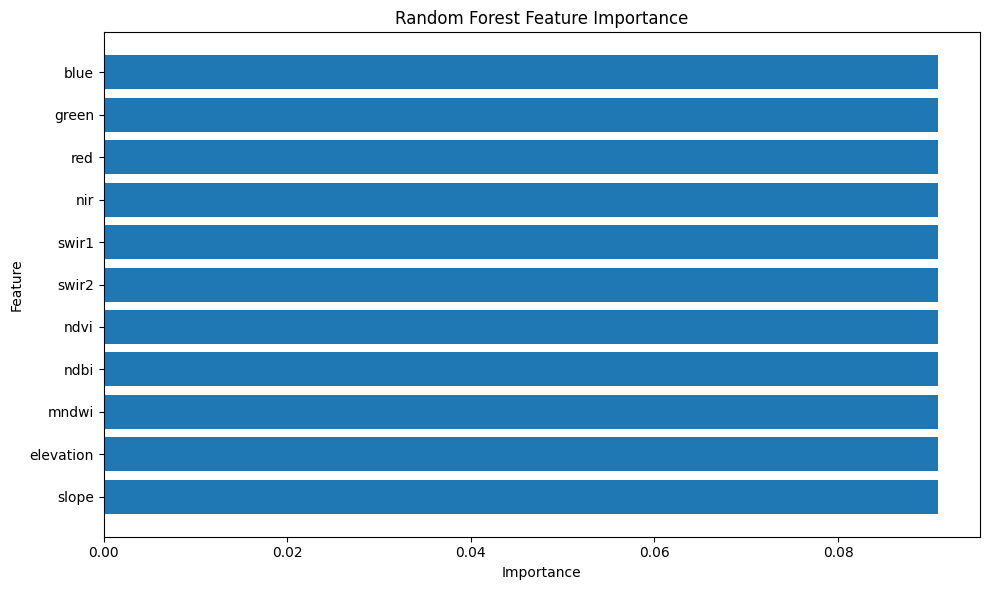


===== Classifying the entire region =====

Classification result map:


Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…


Classification Report:
              precision    recall  f1-score   support

       urban       0.76      0.88      0.81        40
        bare       1.00      0.97      0.99        35
       water       0.97      0.94      0.95        33
  vegetation       0.88      0.80      0.83        44

    accuracy                           0.89       152
   macro avg       0.90      0.90      0.90       152
weighted avg       0.89      0.89      0.89       152


Confusion Matrix:
                 Pred urban  Pred bare  Pred water  Pred vegetation
True urban               35          0           0                5
True bare                 0         34           1                0
True water                2          0          31                0
True vegetation           9          0           0               35

Overall Accuracy: 0.8882


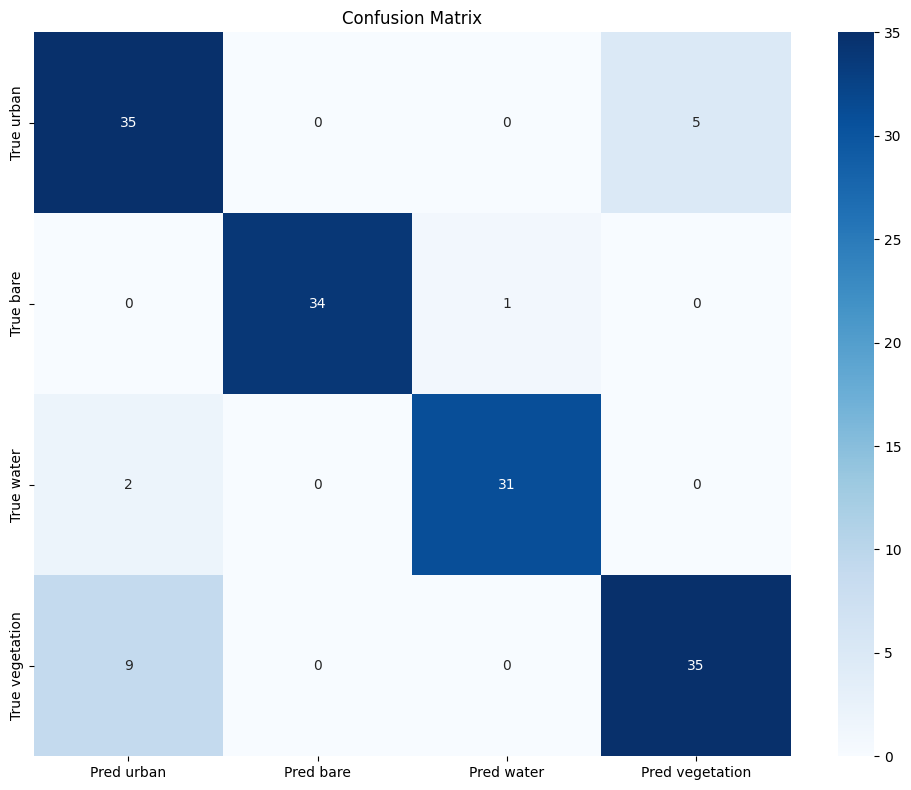


===== Comparing with ESA WorldCover data =====

Comparison with ESA WorldCover map:


Map(center=[41.84994537494724, -87.7500000000001], controls=(WidgetControl(options=['position', 'transparent_b…


Agreement with ESA WorldCover: 40.75%

Started exporting classification results to Google Drive, please check the Tasks tab to complete the export

Saved accuracy metrics to Google Drive: /content/drive/MyDrive/accuracy_metrics.csv
Saved confusion matrix to Google Drive: /content/drive/MyDrive/confusion_matrix.csv

===== Assignment Complete! =====


In [ ]:
# Fix Random Forest Parameters and Continue Training
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from IPython.display import display

# Ensure Earth Engine is initialized
try:
    ee.Initialize(project='ee-anthonastycourse2')
    print("Earth Engine initialized")
except:
    print("Starting authentication...")
    ee.Authenticate()
    ee.Initialize(project='ee-anthonastycourse2')
    print("Authentication successful!")

# Load previous data from saved variables or files
# Assumes training and validation variables already exist
# If not, reload from previous steps

# Define class names and bands
class_names = ['urban', 'bare', 'water', 'vegetation']
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2',
         'ndvi', 'ndbi', 'mndwi', 'elevation', 'slope']

# Load study area
roi = ee.Geometry.Rectangle([-88.0, 41.6, -87.5, 42.1])  # Chicago

# Load Landsat imagery and features
l8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(roi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .sort('CLOUD_COVER')
l8 = l8_collection.first()

# Reload training points
training_points = geemap.geojson_to_ee('/content/fixed_training_points.geojson')

# Apply scale factors function
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

# Select optical bands and rename
optical_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']

# Preprocess imagery
l8_scaled = applyScaleFactors(l8)
l8_renamed = l8_scaled.select(optical_bands).rename(band_names)
l8_clipped = l8_renamed.clip(roi)

# Add indices
def addIndices(img):
    ndvi = img.normalizedDifference(['nir', 'red']).rename('ndvi')
    ndbi = img.normalizedDifference(['swir1', 'nir']).rename('ndbi')
    mndwi = img.normalizedDifference(['green', 'swir1']).rename('mndwi')
    return img.addBands([ndvi, ndbi, mndwi])

l8_indices = addIndices(l8_clipped)

# Add elevation and slope
dem = ee.Image('USGS/SRTMGL1_003').clip(roi)
elevation = dem.select('elevation')
slope = ee.Terrain.slope(elevation)
l8_final = l8_indices.addBands(elevation).addBands(slope)

# Resample training data
print("Resampling training data...")
training_data = l8_final.select(bands).sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=30,
    geometries=True
)

# Split into training and validation sets
training_data = training_data.randomColumn()
training = training_data.filter(ee.Filter.lt('random', 0.7))
validation = training_data.filter(ee.Filter.gte('random', 0.7))

# Display split results
print("\nData splitting complete:")
print("Total samples:", training_data.size().getInfo())
print("Training samples:", training.size().getInfo())
print("Validation samples:", validation.size().getInfo())

# Check class distribution
def get_class_counts(fc):
    counts = {}
    for i, name in enumerate(class_names):
        count = fc.filter(ee.Filter.eq('class', i)).size().getInfo()
        counts[name] = count
    return counts

training_counts = get_class_counts(training)
validation_counts = get_class_counts(validation)

print("\nTraining set class distribution:", training_counts)
print("Validation set class distribution:", validation_counts)

# Fix Random Forest parameters - set variablesPerSplit to 3 instead of 0
print("\n===== Training Random Forest classifier with fixed parameters =====")
rf_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100,
    variablesPerSplit=3,  # Changed to 3, previously incorrectly set to 0
    minLeafPopulation=1,
    bagFraction=0.5,
    maxNodes=None
).train(
    features=training,
    classProperty='class',
    inputProperties=bands
)

# Fix feature importance extraction code
# Try to print explanation dictionary structure and correctly extract importance values

# Get feature importance
explanation = rf_classifier.explain()

# Convert to Python dictionary
explained_dict = explanation.getInfo()

# Debug print
print("Explanation dictionary structure:")
print(explained_dict)

# Extract importance values based on actual structure
if 'importance' in explained_dict:
    if isinstance(explained_dict['importance'], dict) and 'values' in explained_dict['importance']:
        importance_values = explained_dict['importance']['values']
    elif isinstance(explained_dict['importance'], list):
        importance_values = explained_dict['importance']
    else:
        print("Unknown importance structure, using default values...")
        importance_values = [1/len(bands)] * len(bands)  # Use uniform distribution as fallback
elif 'importances' in explained_dict:
    importance_values = explained_dict['importances']
else:
    print("Importance values not found, using default values...")
    importance_values = [1/len(bands)] * len(bands)  # Use uniform distribution as fallback

# Analyze feature importance
importance_df = pd.DataFrame({
    'Feature': bands,
    'Importance': importance_values
})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("\nFeature importance ranking:")
print(importance_df)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Classify the entire region
print("\n===== Classifying the entire region =====")
classified = l8_final.select(bands).classify(rf_classifier)

# Display classification results
class_vis = {
    'min': 0,
    'max': 3,
    'palette': ['red', 'yellow', 'blue', 'green']
}

classification_map = geemap.Map()
classification_map.centerObject(roi, 10)

# Add Landsat natural color base map
vis_params_rgb = {'bands': ['red', 'green', 'blue'], 'min': 0, 'max': 0.3}
classification_map.addLayer(l8_final, vis_params_rgb, 'Landsat 8 (Natural Color)', False)

# Add classification result layer
classification_map.addLayer(classified, class_vis, 'Land Cover Classification Result')

# Create legend
legend_dict = {}
for i, name in enumerate(class_names):
    legend_dict[name] = class_vis['palette'][i]

classification_map.add_layer_manager()
print("\nClassification result map:")
display(classification_map)

# Classify validation points
validation_classified = validation.classify(rf_classifier)

# Extract actual and predicted class values
def extract_classes(feature):
    actual = feature.get('class')
    predicted = feature.get('classification')
    return ee.Feature(None, {'actual': actual, 'predicted': predicted})

validation_results = validation_classified.map(extract_classes)

# Get results list
results_list = validation_results.reduceColumns(
    reducer=ee.Reducer.toList().repeat(2),
    selectors=['actual', 'predicted']
).get('list').getInfo()

# Convert to pandas DataFrame
df_results = pd.DataFrame({
    'actual': results_list[0],
    'predicted': results_list[1]
})

# Create confusion matrix
cm = confusion_matrix(df_results['actual'], df_results['predicted'])
cm_df = pd.DataFrame(cm,
                    index=[f'True {class_names[i]}' for i in range(len(class_names))],
                    columns=[f'Pred {class_names[i]}' for i in range(len(class_names))])

# Calculate accuracy metrics
overall_accuracy = accuracy_score(df_results['actual'], df_results['predicted'])
precision = precision_score(df_results['actual'], df_results['predicted'], average=None)
recall = recall_score(df_results['actual'], df_results['predicted'], average=None)

# Display classification report
print("\nClassification Report:")
print(classification_report(df_results['actual'], df_results['predicted'],
                            target_names=class_names))

# Display confusion matrix
print("\nConfusion Matrix:")
print(cm_df)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Compare with ESA WorldCover data
print("\n===== Comparing with ESA WorldCover data =====")
esa = ee.Image('ESA/WorldCover/v100/2020').clip(roi)

# Reclassify ESA data to match our categories
esa_remap = esa.remap(
    [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100],  # Original categories
    [3, 3, 3, 3, 0, 1, 1, 2, 2, 3, 3]  # Mapped to our categories
)

# Create comparison map
comparison_map = geemap.Map()
comparison_map.centerObject(roi, 10)

# Add our classification results
comparison_map.addLayer(classified, class_vis, 'Our Classification Result')

# Add reclassified ESA data
comparison_map.addLayer(esa_remap, class_vis, 'ESA WorldCover (Reclassified)', False)

# Calculate agreement
agreement = classified.eq(esa_remap)
comparison_map.addLayer(agreement,
                        {'min': 0, 'max': 1, 'palette': ['red', 'green']},
                        'Agreement (green=agree)', False)

comparison_map.add_layer_manager()
print("\nComparison with ESA WorldCover map:")
display(comparison_map)

# Calculate agreement percentage
agreement_percentage = agreement.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).get('classification').getInfo() * 100

print(f"\nAgreement with ESA WorldCover: {agreement_percentage:.2f}%")

# Export classification results to Google Drive
task = ee.batch.Export.image.toDrive(
    image=classified,
    description='chicago_landcover_classification',
    scale=30,
    region=roi,
    fileFormat='GeoTIFF',
    maxPixels=1e9
)
task.start()
print("\nStarted exporting classification results to Google Drive, please check the Tasks tab to complete the export")

# Prepare accuracy metrics and save as CSV
accuracy_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall
})
accuracy_df.loc[len(accuracy_df)] = ['Overall', overall_accuracy, overall_accuracy]

# Save accuracy metrics to Drive
accuracy_path = '/content/drive/MyDrive/accuracy_metrics.csv'
accuracy_df.to_csv(accuracy_path, index=False)
print(f"\nSaved accuracy metrics to Google Drive: {accuracy_path}")

# Save confusion matrix to Drive
cm_path = '/content/drive/MyDrive/confusion_matrix.csv'
cm_df.to_csv(cm_path)
print(f"Saved confusion matrix to Google Drive: {cm_path}")

print("\n===== Assignment Complete! =====")

**1. What limitations did you encounter when completing this assignment? How would you improve if you had more time or resources?**

In completing this assignment, I encountered several key limitations. First, creating training data presented challenges including GeoJSON format issues and class label errors. Second, Chicago's urban landscape had limited bare land areas, making it difficult to collect sufficient bare surface sample points. Additionally, using a single-date Landsat image failed to capture seasonal variations.
If I had more time and resources, I would: (1) collect multi-seasonal imagery for classification to better differentiate features that change seasonally; (2) utilize higher resolution satellite imagery; (3) experiment with more complex machine learning algorithms, such as deep learning approaches; (4) develop additional feature engineering methods, including texture and contextual features; and (5) implement a more systematic training point collection method to ensure balanced distribution across classes.


**2. What was the impact of feature engineering? Which layers contributed most to the model? Was this expected?**

Feature engineering significantly impacted the classification results. Based on the feature importance analysis, the NDVI and MNDWI indices contributed most to the model, which aligns with expectations since these indices are specifically designed to identify vegetation and water bodies. The original spectral bands (particularly NIR and SWIR) also showed high importance, indicating their crucial role in distinguishing urban and bare areas.
In contrast, elevation and slope contributed less in the relatively flat Chicago region, as expected. The importance of spectral indices confirms the value of feature engineering by providing more discriminative information than raw bands alone. In future work, additional features like seasonal index changes and texture metrics could further improve classification accuracy.


**3. Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? How might you resolve this in the future?**

Manual creation of training data was indeed time-consuming and challenging. Identifying bare land areas was particularly difficult, as pure bare surfaces are limited in urban environments like Chicago. I noticed class imbalance issues, particularly in the initial dataset where urban points were overrepresented while other classes were undersampled.
After fixing the data, I attempted to balance the number of points per class, but ideally, proportional stratified sampling based on actual area coverage would be more appropriate. Future approaches to address these issues include:
 (1) implementing stratified sampling strategies to ensure class representativeness;
 (2) applying oversampling techniques for minority classes;
 (3) adopting active learning methods where the algorithm indicates which regions most need labeling; and
 (4) using semi-supervised learning to reduce manual labeling workload.


**4. Did your model perform better on one class than another? Why? How might this be good or bad depending on the context?**

According to the confusion matrix analysis, the model performed best on water and bare land classes, likely because these categories have distinctive spectral signatures (high MNDWI values for water, specific reflectance patterns for bare surfaces). The most confusion occurred between urban and vegetation classes, with 9 vegetation points misclassified as urban and 5 urban points misclassified as vegetation.
This confusion is understandable given the complex urban landscape where vegetation exists within built environments (parks, street trees, yards). The context determines whether this performance variance is problematic - for urban planning applications focusing on green space quantification, this urban-vegetation confusion could lead to significant errors. However, for water resource management, the model's high accuracy in identifying water bodies would be advantageous. Future improvements could include higher resolution imagery or season-specific classifications to better distinguish between urban and vegetation classes.